# Initial Automatic Detection
This notebook uses the same data as the Combined_UBurn_WorkBook but runs an analysis to detect burn scars.

Similarly to the main notebook, the first couple of cells will set the initial configuration and allow you to choose the case study/dataset of interest. After these have been selected, the following cells will load and show an interactive data frame that allows you to filter out the data you want to investigate.
**Note:** If the notebook is run with one set of options and then changed, e.g. swapping from coherence to backscatter, then there may be errors. So try shutting done the notebook and running again if this happens.

In [4]:
#Reload modules without shutting notebook
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import rasterio
from rasterio.windows import Window
import datetime
import pandas as pd
import geojson as gj
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt 
from ipywidgets import Dropdown, interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Upland burn utils
from utils.array_creation import generate_array, generate_array_backscatter, get_window
from utils.get_configuration import get_configuration, get_config
from utils.functions import order_files_by_date, get_data_dict, get_aoi_date_dict, get_polygon_list
from utils.analysis import run_analysis, threshold

current_burn = None
home = os.path.expanduser("~")
shared_folder = os.path.join(home, "my_shared_data_folder")
datasets = os.path.join(shared_folder, "datasets")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
workbook_widget = Dropdown(options = ["", "Coherence", "Backscatter"], description = "Dataset:", value = "")
def change_wbook(*args):
    global workbook 
    workbook = workbook_widget.value
    if workbook == "":
        return

workbook_widget.observe(change_wbook, 'value')
print("Choose the type of data to look at")
display(workbook_widget)

cstudy_widget = Dropdown(options = ["", "skye", "cairngorms", "pdistrict"], description = "Case study:", value = "")
def change_cstudy(*args):
    global cstudy 
    global aoi
    global poly_list
    global poly_dict
    global polygons
    cstudy = cstudy_widget.value
    length = 3 # Number of characters in the id number
    if cstudy == "":
        poly_list = []
        return
    elif cstudy == "skye":
        aoi = os.path.join(datasets, "Skye_extent_OSGB36.geojson")
    elif cstudy == "cairngorms":
        aoi = os.path.join(datasets, "Cairngorms_extent_OSGB36-extended.geojson")    
    else:
        aoi = os.path.join(datasets, "PDistrict_extent_OSGB36.geojson")
        length = 5
    poly_list = get_polygon_list(datasets, aoi)
    date_dict = get_aoi_date_dict(cstudy, shared_folder)
    
    ###  Below needs updating when we get dates for burns ###    
    fstart = os.path.basename(aoi).split("_")[0]
    searchstr = fstart + "_burn_extent_*.geojson"
    polygons = glob.glob(os.path.join(datasets, searchstr))
    if len(polygons) == 0:
        print("No polygons exist for {}".format(searchstr))
    poly_list = []
    for poly in polygons:
        fpoly = os.path.splitext(os.path.basename(poly))[0]
        poly_list.append(fpoly.split("_")[3])

    test_dates = []    
    # Convert string list to int list, sort then convert back
    poly_int = [i for i in poly_list]
    poly_int.sort()
    poly_list = [str(i).zfill(3) for i in poly_int]
    poly_list2 = [pol + " (%s)"%(date_dict[int(pol[:length])]) for pol in poly_list]

    poly_dict = {pol_string : pol for pol, pol_string in zip(poly_list, poly_list2)}
    b_widget.options = poly_dict.keys()
    del poly_int
    
cstudy_widget.observe(change_cstudy, 'value')
print("Choose a Case study area")
display(cstudy_widget)

poly_dict = {}
b_widget = Dropdown(options = poly_dict.keys(), description = "Polygon:")
def change_x(*args):
    print("Set to {}".format(b_widget.value))

# Create a widget that can be used the choose the polygon of interest
version_widget = Dropdown(options = ["v2", "v1"], description = "Version:")
def change_version(*args):
    print("Set to {}".format(version_widget.value))
    
version_widget.observe(change_version, 'value')
print("Choose dataset version")
display(version_widget)

Choose the type of data to look at


Dropdown(description='Dataset:', options=('', 'Coherence', 'Backscatter'), value='')

Choose a Case study area


Dropdown(description='Case study:', options=('', 'skye', 'cairngorms', 'pdistrict'), value='')

Choose dataset version


Dropdown(description='Version:', options=('v2', 'v1'), value='v2')

In [7]:
if version_widget.value == "v2":
    v2=True
    ofiles, outfolder, baselines = get_config(cstudy, workbook, v2=v2)
    if len(ofiles) == 0:
        print("No v2 data, switching to v1")
        v2=False
else:
    v2=False
    ofiles, outfolder, baselines = get_config(cstudy, workbook, v2=v2)
    if len(ofiles) == 0:
        print("No v1 data, switching to v2")
        v2=True
ofiles, outfolder, baselines = get_config(cstudy, workbook, v2=v2)
if len(ofiles) == 0:
     raise SystemExit("No valid data found")
else:
    print("Found %s potential files and %s baselines"%(len(ofiles), len(baselines)))

    only_VV = [file for file in ofiles if "VV" in file]
only_VH = [file for file in ofiles if "VH" in file]
bands = set([file.strip("_%s.tif"%(cstudy))[-2:] for file in ofiles])
polar_dict = {'VV' : 0, 'VH' : 1}
pol, other_pol = "VV", "VH"
if workbook == "Coherence":
    if len(only_VV) > len(only_VH):
        most_files = only_VV
    else:
        most_files = only_VH
        pol, other_pol = "VH", "VV" 
else:
    most_files = ofiles
most_files = order_files_by_date(most_files, workbook) # this should fix date issue in dataframe 
data_dict = get_data_dict(most_files, workbook, baselines)

pd.set_option('display.max_rows', 500)
df = pd.DataFrame.from_dict(data_dict)

Loaded configuration: {'sharedfolder': 'my_shared_data_folder/my_shared_data_folder'}.
Could not find any files in /home/slavender/my_shared_data_folder/my_shared_data_folder/skye/coherence_tiffs2
No v2 data, switching to v1
Loaded configuration: {'sharedfolder': 'my_shared_data_folder/my_shared_data_folder'}.
Loading baselines from /home/slavender/my_shared_data_folder/my_shared_data_folder/datasets/baselines/baselines_skye.p
Found 18 potential files and 230 baselines


In [8]:
chosen_orbit = 'All'
chosen_direction = 'both'        
def get_files_by_date(start_date, end_date, rel_orbit, orbit_dir, sensor):
    global chosen_orbit
    global chosen_direction
    global time_filtered_df
    time_filtered_df = df[(df['date'] >= pd.to_datetime(start_date)) & (df['date'] <= pd.to_datetime(end_date))]
    if rel_orbit != "":
        time_filtered_df = time_filtered_df[time_filtered_df["rorbit"] == rel_orbit]
        chosen_orbit = "All"
    if orbit_dir != "":
        time_filtered_df = time_filtered_df[time_filtered_df["direction"] == orbit_dir]
        chosen_direction = "Both"
    if len(set(time_filtered_df.direction.values)) == 1:
        orbit_dir = time_filtered_df.direction.values[0]
    if sensor != "":
        time_filtered_df = time_filtered_df[time_filtered_df["sensor"].isin(["BA", "AB"])]
    time_filtered_df_vis = time_filtered_df.copy(deep=True)
    chosen_orbit = rel_orbit
    chosen_direction = orbit_dir        
    return time_filtered_df_vis.drop(['filename', 'polarisation'], axis = 1)

orbit_opts = list(set(df['rorbit'].values))
orbit_opts.append("")
orbit_dir_opts = list(set(df['direction'].values))
orbit_dir_opts.append("")

sensor_opts = list(set(df['sensor'].values))
sensor_opts.append("")
interact(get_files_by_date,
        start_date=widgets.DatePicker(value=pd.to_datetime(min(df['date']))),
        end_date=widgets.DatePicker(value=pd.to_datetime(max(df['date']))),
        rel_orbit=widgets.Dropdown(options=orbit_opts, value = ""),
        orbit_dir=widgets.Dropdown(options=orbit_dir_opts, value = ""),
        sensor=widgets.Dropdown(options=sensor_opts, value = ""))

interactive(children=(DatePicker(value=Timestamp('2018-02-01 00:00:00'), description='start_date'), DatePicker…

<function __main__.get_files_by_date(start_date, end_date, rel_orbit, orbit_dir, sensor)>

In [9]:
# Check the number of files selected as too many cause memory problems - for now, sets a limit of 20
# Analysis should also be run on a single relative orbit
wanted_files = time_filtered_df.filename.to_list()
if len(wanted_files) > 20:
    raise SystemExit("Too many files chose a shorter date range, and make sure a single relative orbit is selected")

## Load data and run pre-processing
Th next cell loads the images into an array, and the the following cell runs the analysis (which is currently denormalisation followed by a Gaussian filter with a sigma of 5). 
The analysis steps can be adjusted and or different steps can be added at a different point. More information on how to do this is in the second cell. 

In [10]:
wanted_files = time_filtered_df.filename.to_list()
for n, file in enumerate(wanted_files):
    with rasterio.open(file) as src:
        arr = src.read()
    if n == 0:
        all_arrays = np.zeros((len(wanted_files), arr.shape[1], arr.shape[2]))
    all_arrays[n] = arr[0]


In [11]:
# Analysis options - check analysis.py in utils for how each of these work - the value after the hyphen specifies the parameter for 
# that analysis. i.e. the nuumber of iterations, the size (in pixels), the percentile (for threshold), 
# or median / mean (for threshold - thresh-median)
# [ "denorm", "gauss-5", "threshold-10", "dilate-2", "size-50", "gauss-5", "erode-4", "close", "diff"] 

# create a list of the analysis you want to run (in order)
list_of_analysis = ["denorm", "gauss-10"]

# loop through the array and run the anlysis - N.B. You can do another loop of different analysis at any point if you wish
analysed_array = np.copy(all_arrays)
for analysis in list_of_analysis:
    print("Running %s"%(analysis))
    analysed_array = run_analysis(analysed_array, analysis)
    print("Done")
    
print("Setting water to 0")
analysed_array[all_arrays == 0] = 0
print("All the analysis is complete, array created:", analysed_array.shape)

Running denorm
Done
Running gauss-10
Done
Setting water to 0
All the analysis is complete, array created: (9, 7993, 5993)


## Calculate the temporal mean
The following cell normalises each individual array by the maximum across all arrays and displays the temporal mean. Then, the following cell caluclates the difference between each array and the temporal mean and applies a second gaussian filter (again sigma of 5).

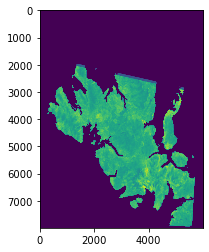

In [12]:
# Calculate the temperal mean image
for n, arr in enumerate(analysed_array):
    # divide each individual array by the combined maximum
    arr = arr / np.nanmax(analysed_array)
    analysed_array[n] = arr
# get the mean and max values across all arrays
temporal_mean = np.nanmean(analysed_array, axis=0)
temporal_max = np.nanmax(analysed_array, axis=0)
plt.figure()
plt.imshow(temporal_mean)
plt.show()

In [13]:
for n, arr in enumerate(analysed_array):
    arr = abs(arr - temporal_mean) # get the difference between each array and the temporal mean
    arr = gaussian_filter(arr, sigma=5) # smooth the array to reduce noise
    analysed_array[n] = arr

# determine the total change for each pixel 
total_coherence_array = np.sum(analysed_array, axis=0)
analysed_array = None

## Thresholding
The foollowing three cells threshold the image to provide us with a potential prediction, loads the known burn areas into a ground truth array for comparison, and then displays the results before returning an accuracy and precision score.

In [14]:
pred = np.zeros(total_coherence_array.shape)
# determine the threshold and set values above it to 1 to create a prediction label
thresh = threshold(total_coherence_array, threshtype="median") 
#thresh = threshold(total_coherence_array, perc=95)
#thresh = threshold(total_coherence_array, threshtype="mean") 

pred[total_coherence_array > thresh] = 1

In [15]:
# This imports the polygons for the case study and creates a ground truth mask
import gdal 
import geojson as gj
from PIL import Image, ImageDraw
import rasterio 

def get_polygon_vector(polygon_file, xOrigin, yOrigin, pixelWidth, pixelHeight):
    vect = []
    with open (polygon_file, 'r') as f:
        loadg = gj.loads(f.read())
        x, y = zip(*gj.utils.coords(loadg))
    for x1, y1 in zip(x, y):
        xpix = ((x1 - xOrigin) / pixelWidth)
        ypix = ((yOrigin - y1) / pixelHeight)
        #vect.append([int(ypix), int(xpix)])
        vect.append(int(xpix))
        vect.append(int(ypix))
    return vect

def create_burn_mask(polygons, example_file):
    ds = gdal.Open(example_file, gdal.GA_ReadOnly)
    bands = ds.RasterCount
    image = ds.GetRasterBand(1).ReadAsArray()
    # Getting georeference info
    transform = ds.GetGeoTransform()
    projection = ds.GetProjection()
    xOrigin = transform[0] # top left x 
    yOrigin = transform[3] # top left y 
    pixelWidth = transform[1] # w-e pixel resolution 
    pixelHeight = -transform[5]
    del ds
    
    xdim, ydim = image.shape
    vectors = []
    for p in polygons:
        vect = get_polygon_vector(p, xOrigin, yOrigin, pixelWidth, pixelHeight)
        vectors.append(vect)
    img = Image.new('L',  (ydim,xdim), 0)                                                                                                                                                                                                                  
    draw = ImageDraw.Draw(img)  
    for vect in vectors:
        draw.polygon(vect, fill=1)
    mask = np.array(img)
    return mask

ground_truth = create_burn_mask(polygons, wanted_files[0])

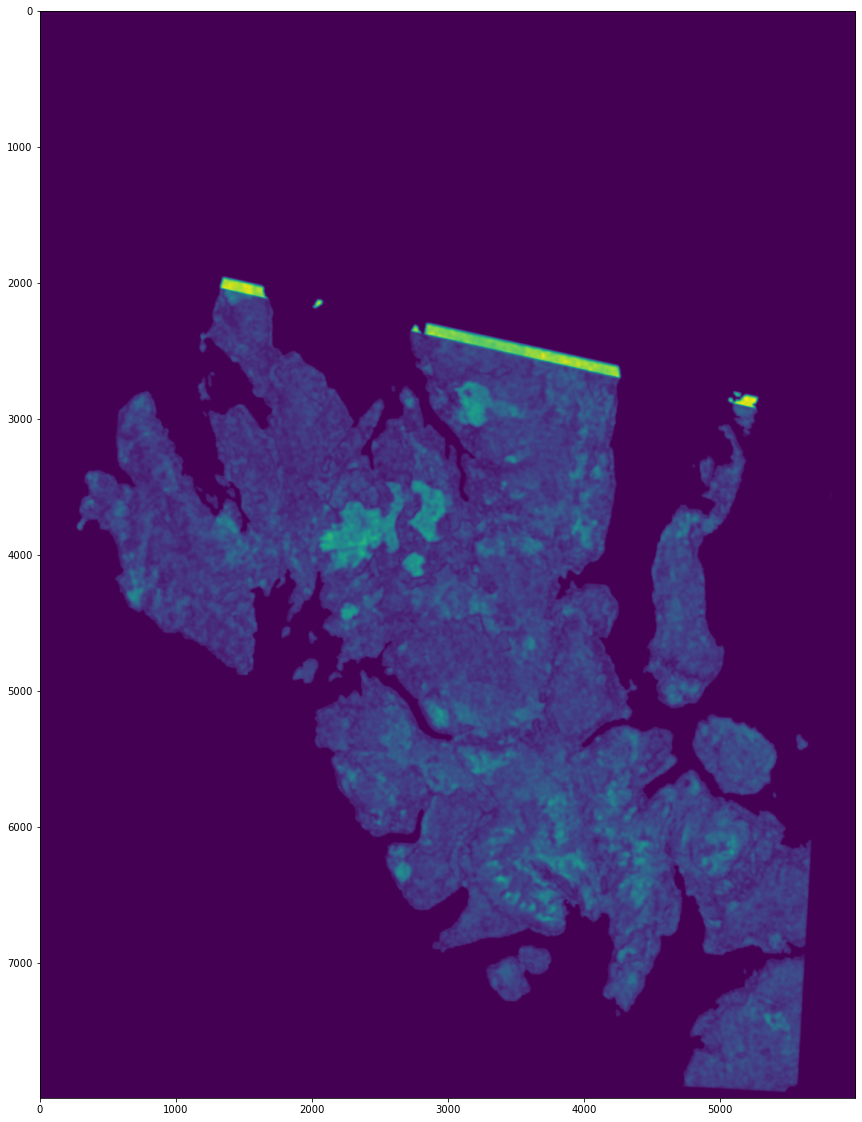

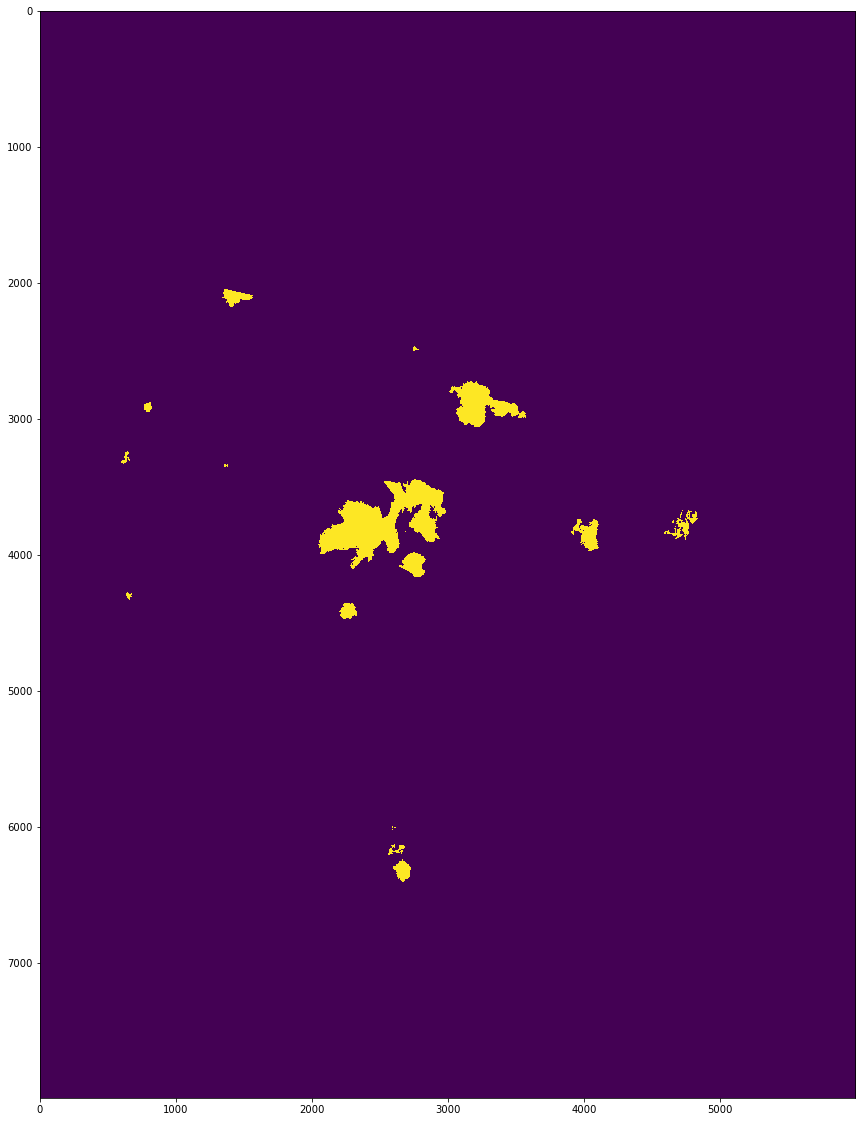

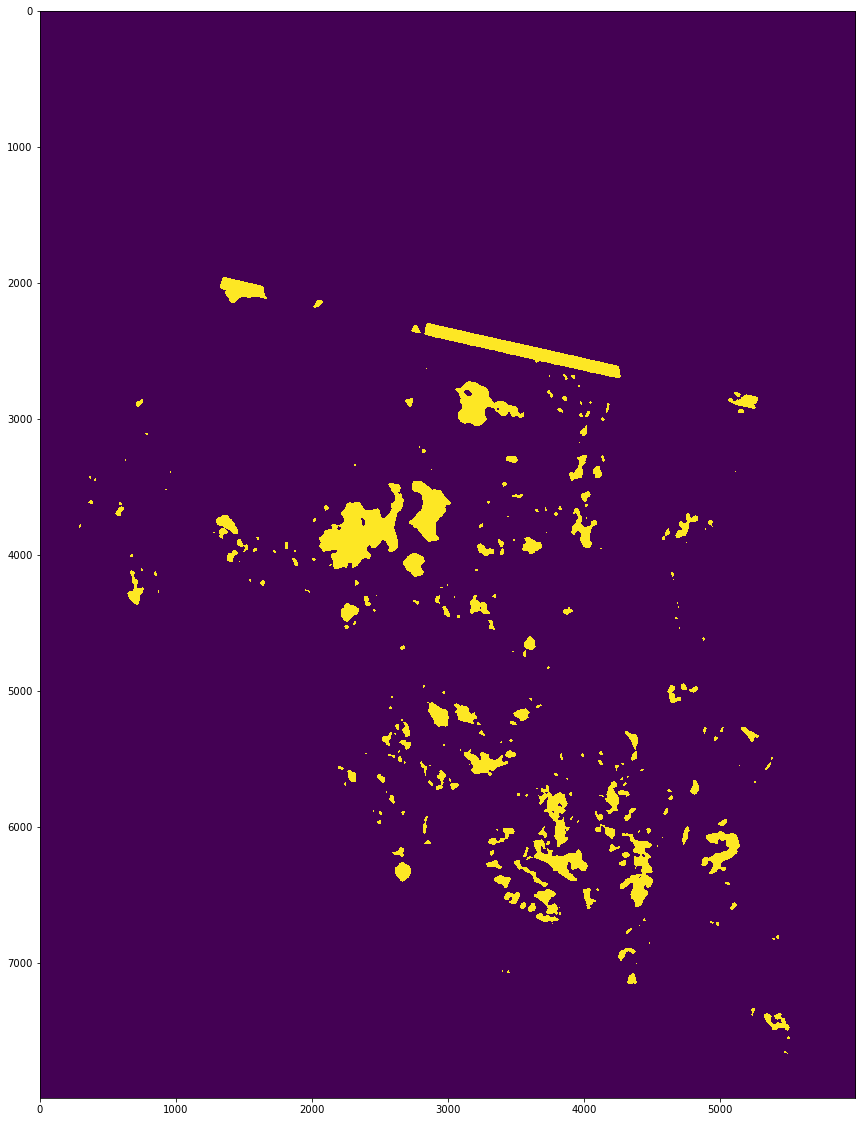

Accuracy:  79.22410805602279
Precison:  29.586299852114667


In [16]:
# set all the water values to 0 
ground_truth[all_arrays[0, :, :] == 0]=0

plt.figure(figsize=(20,20))
plt.imshow(total_coherence_array)
plt.figure(figsize=(20,20))
plt.imshow(ground_truth)
plt.figure(figsize=(20,20))
plt.imshow(pred)
plt.show()

print("Accuracy: ", (np.sum(pred[ground_truth==1]) / np.sum(ground_truth))*100)
print("Precison: ", (np.sum(ground_truth[pred==1]) / np.sum(pred)) * 100)

## Save the images
The final two cells allow the prediction, ground truth array and / or the pre thresholded total change in coherence image to be saved either as a simple png, or projected to the correct coordinate system and saved as a GeoTIFF.

In [17]:
import matplotlib
# unhash to save the output arrays (non - projected)

#matplotlib.image.imsave(os.path.join(outfolder, "%s_change.png"%(cstudy)), total_coherence_array)
#matplotlib.image.imsave(os.path.join(outfolder, "%s_pred.png"(cstudy)), pred)
#matplotlib.image.imsave(os.path.join(outfolder, "%s_groundtruth.png"(cstudy)), ground_truth)

In [18]:
import rasterio 
from rasterio.windows import Window

# Used to output a reprojected version of ground_truth, pred or total_coherence_array
# set which one you want to output, set the name of the file (the cstudy area will be appended to the end of it)
out_arr = ground_truth
out_name = "ground_truth"

# create the file name
filepathraw = os.path.join(outfolder, "%s_%s.tif"%(out_name, cstudy))

ymin, ymax, xmin, xmax = 0, out_arr.shape[0], 0, out_arr.shape[1]
# create a window and open the file
win = Window.from_slices((ymin, ymax), (xmin, xmax))
with rasterio.open(wanted_files[0]) as src:
    arr = src.read(window = win)
# get the transformation info
transform = src.window_transform(win)
width = xmax - xmin
height = ymax - ymin

#update the kwargs
kwargs = src.meta.copy()
kwargs.update({
    'transform': transform,
    'width': out_arr.shape[1],
    'height': out_arr.shape[0],
    'dtype' : out_arr.dtype,
    'count' : 1,
    'driver' : 'GTiff',
})

with rasterio.open(filepathraw, 'w', **kwargs) as dst:
    dst.write(np.expand_dims(out_arr, axis=0))
print("Wrote georeferenced image to %s"%(filepathraw))

Wrote georeferenced image to /home/slavender/notebooks/output_folder/ground_truth_skye.tif
